##### Random Forest Modeling

In [56]:
# importing useful modules
#import Library of python
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import datetime 
import logging
sys.path.append('../src')
import warnings
warnings.filterwarnings('ignore')
from file_handler import FileHandler
from clean_data import data_preProcessing_script
from visualize_data import visualize
from cleaner import DataCleaner
File_handler=FileHandler()
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import mlflow
from pickle import dump
import mlflow.sklearn
from numpy.core.umath_tests import inner1d
import category_encoders as ce
%matplotlib inline
import pickle

In [43]:
# The load the raw sales data
data_path = '../data/train_store_label.csv'
version = 'vsl1'
repo = '../'

#train_train_model_df = File_handler.dvc_get_data(data_path, version, repo)
train_train_model_df=pd.read_csv(data_path)

#### Build Sklearn model

##### Split Data set as Train and Test

In [16]:
#use sales as target variable
X = train_train_model_df.drop(['Customers', 'Sales'], axis = 1)
y = train_train_model_df['Sales']

In [17]:
# Split train, validate, test with ratio of 70:20:10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=85)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=85)
print ("Training, Validating and Testing Dataset split was successful Done.")

Training, Validating and Testing Dataset split was successful Done.


In [18]:
#Creat the Skelearn Pipeline using random forest
model_pipeline = Pipeline(steps=[('random_forest', RandomForestRegressor(max_depth=10,random_state=2))])

##### Define evaluation metrics

In [19]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    print("RMSE Score is: {:.5%}".format(rmse))
    print("R2 Square Score is: {:.5%}".format(r2))
    print("MAE Score is: {:.5%}".format(mae))
    return {f'RMSE Score': rmse, f'R2_Squared': r2, f'MAE Score': mae}

#### Pipeline for model

In [20]:
# Fit the pipeline with the dataset
mlflow.autolog(log_input_examples=True, disable_for_unsupported_versions=True, silent=True)
with mlflow.start_run() as run:
    best_model = model_pipeline.fit(X_train, y_train)

    train_score = best_model.score(X_train, y_train)
    valid_score = best_model.score(X_valid, y_valid)
    valid_metrics = eval_metrics(y_valid, best_model.predict(X_valid))
    test_score = best_model.score(X_test, y_test)
    test_metrics = eval_metrics(y_test, best_model.predict(X_test))

    mlflow.log_metric("Valid Score", valid_score)
    mlflow.log_metrics(valid_metrics)
    mlflow.log_metric("Test Score", test_score)
    mlflow.log_metrics(test_metrics)

RMSE Score is: 53.62851%
R2 Square Score is: 71.18533%
MAE Score is: 38.44882%
RMSE Score is: 53.63901%
R2 Square Score is: 71.33190%
MAE Score is: 38.40962%


#### Hyperparamete tuning using random forest algorithm

In [21]:
# Create dictionary with candidate learning algorithms and their hyperparameters
grid_param = [{
     'random_forest': [RandomForestRegressor(max_depth=10, random_state=42)],
     'random_forest__bootstrap': [True, True],
     'random_forest__ccp_alpha': [0.0],
     'random_forest__criterion': ['mse'],
     'random_forest__max_depth': [5,8,15],
     'random_forest__max_features': ['auto'],
#      'random_forest__max_leaf_nodes': None,
#      'random_forest__max_samples': None,
     'random_forest__min_impurity_decrease': [0.0],
#      'random_forest__min_impurity_split': None,
     'random_forest__min_samples_leaf': [1,5],
     'random_forest__min_samples_split': [2],
     'random_forest__min_weight_fraction_leaf': [0.0],
     'random_forest__n_estimators': [100],
#      'random_forest__n_jobs': None,
     'random_forest__oob_score': [False, True],
     'random_forest__random_state': [2],
     'random_forest__verbose': [0],
     'random_forest__warm_start': [True, False]
}]

    
# create a gridsearch of the pipeline, the fit the best model
grid_search_pipeline = GridSearchCV(
    model_pipeline, grid_param, cv=3, verbose=0, n_jobs=-1)  

Generate model name

In [71]:
def generate_model_name(mse_score: float) -> str:
    now = datetime.now()
    dt_string = now.strftime("%d-%m-%Y-%H-%M-%S-")
    dt_string = dt_string + "{:.2%}".format(mse_score)
    return dt_string

#### Validation Results

In [45]:
valid_metrics

{'RMSE Score': 0.5362850838827523,
 'R2_Squared': 0.7118532594227123,
 'MAE Score': 0.3844882028285244}

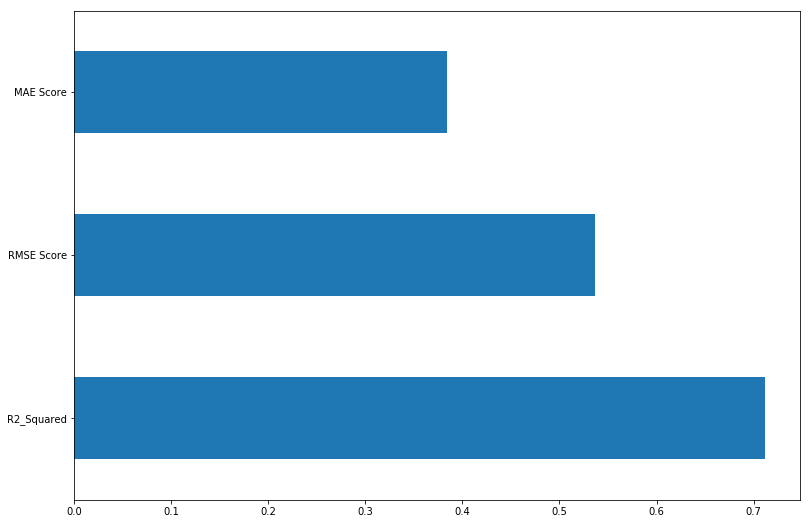

In [57]:
plt.figure(figsize=(13,9))
feat_importances = pd.Series(valid_metrics, index = valid_metrics.keys())
feat_importances.nlargest(10).plot(kind='barh');

#### Testing Results 

In [47]:
test_metrics

{'RMSE Score': 0.5363901008169621,
 'R2_Squared': 0.713318982454849,
 'MAE Score': 0.3840961567020896}

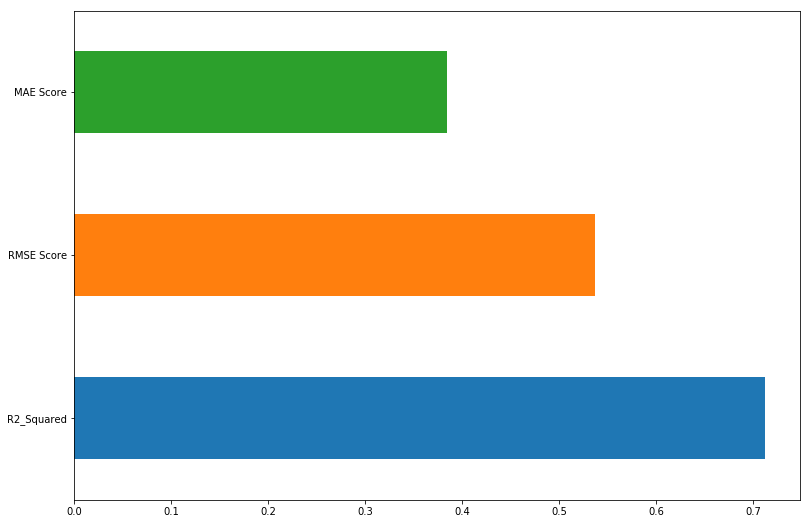

In [31]:
plt.figure(figsize=(13,9))
feat_importances = pd.Series(test_metrics, index = test_metrics.keys())
feat_importances.nlargest(10).plot(kind='barh');

- The RMSE values between 0.2 and 0.60 shows that the model can relatively predict the data accurately.
- The R-squared more than 0.70 is a very good value for showing the accuracy

#### Save model with generate model name

In [77]:
def save_model(model, mse_score) -> None:
    try:
        file_name = '../models/' + generate_model_name(mse_score=mse_score) +'.pkl'
        with open(file_name, 'wb') as handle:
            dump(model, handle)
    except Exception as e:
        print('Error message producing model')

In [ ]:
save_model(best_model, test_metrics['RMSE Score'])

In [58]:
best_model.get_params()

{'memory': None,
 'steps': [('random_forest',
   RandomForestRegressor(max_depth=10, random_state=2))],
 'verbose': False,
 'random_forest': RandomForestRegressor(max_depth=10, random_state=2),
 'random_forest__bootstrap': True,
 'random_forest__ccp_alpha': 0.0,
 'random_forest__criterion': 'squared_error',
 'random_forest__max_depth': 10,
 'random_forest__max_features': 'auto',
 'random_forest__max_leaf_nodes': None,
 'random_forest__max_samples': None,
 'random_forest__min_impurity_decrease': 0.0,
 'random_forest__min_samples_leaf': 1,
 'random_forest__min_samples_split': 2,
 'random_forest__min_weight_fraction_leaf': 0.0,
 'random_forest__n_estimators': 100,
 'random_forest__n_jobs': None,
 'random_forest__oob_score': False,
 'random_forest__random_state': 2,
 'random_forest__verbose': 0,
 'random_forest__warm_start': False}

In [84]:
def rmspe(y, y_pred):
    rmspe = np.sqrt(np.mean( (y - y_pred)**2 ))
    return rmspe

error=rmspe(y_train,y_valid)
error

nan

#### Feature importance

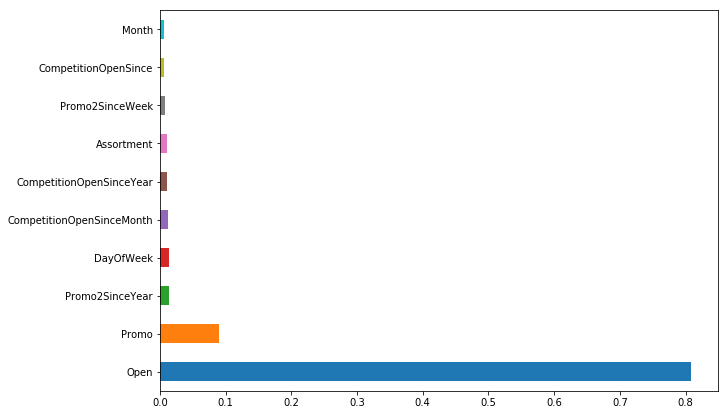

In [37]:
plt.figure(figsize=(10,7))
feat_importances = pd.Series(best_model.steps[0][1].feature_importances_, index = X.columns)
feat_importances.nlargest(10).plot(kind='barh');

The Feature importance show us the Open columns more important than other feature

==============//==============================